In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error
from astropy.cosmology import FlatLambdaCDM
from os import listdir
import desispec
import desispec.io
import speclite.filters
import scipy
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from desitarget.cmx.cmx_targetmask import cmx_mask

In [2]:
zall_path="/project/projectdirs/desi/spectro/redux/everest/zcatalog/ztile-main-bright-cumulative.fits"
data=Table.read(zall_path,hdu=1)
data
#target_ids=np.loadtxt("/global/homes/a/ashodkh/results/target_ids.txt",dtype=int,delimiter=',')

TARGETID,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKID,BRICK_OBJID,MORPHTYPE,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,BRICKNAME,EBV,FLUX_W1,FLUX_W2,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG
int64,float64,float64,float64,float64,int64,int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
39632936659586030,8600.397160291672,985.5694764302397 .. -0.9250422039916643,0.17450133850871147,7.811871000917407e-06,0,7873,GALAXY,--,10,906.8304872512817,0,311,311,0,0,254.02866836295993,32.78814601058069,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,80.712036,-287.91705,2100,0.8898045796160657,575,9011,510108,3054,SER,12.205129,22.924026,35.192436,150.91078,43.26742,12.4266405,0,0,--,0.0,0.0,0.0,0.0,2539p327,0.027328046,27.855787,19.979593,3.0489094,0.92114526,3.0741308,5.7739215,8.863991,3.0741308,5.7739215,8.863991,1.9564737,1.7098395,-0.33519897,0.13100317,N,2100,2,5764607523034234880,514,0,131072,254.02866836295993,32.78814601058069,20923,1,399.2758,1,1,0.008,0.008,0.005,0.005,254.02870679344207,0.0,32.788126404313665,0.0,0.73569846,80.708,-287.916,23.50003,0.012787128,4.5584435,8.913334,72.70694,33.13909,0.3045946,0.13213284,2208.5396,4.484039,410.32153,0.008293948,471.01175,2619.2017,1.2770199,6.8021874,3.074143e-06,13.600328,5.948788e-07,0.0,661.5433,4.3021787e-06,2.5912364,6.6755443,2232.0396,18.097155,414.87997,8.921628,1205.262,2652.3408,4.1728506,13.609865
39632936663777376,9021.754892468452,871.9260459704543 .. 40.79161971225653,0.30910522424493664,1.1304665749608628e-05,0,7867,GALAXY,--,10,1289.5664004087448,0,272,272,1,0,254.1392079087519,32.86372159877973,0.0,0.0,2015.5,5400.0,5764607523034234880,1,TGT,57.371033,-268.13828,2100,0.9392995008920402,575,9011,510109,96,EXP,3.952269,7.981074,13.998019,326.39526,101.58494,37.38392,0,0,--,0.0,0.0,0.0,0.0,2542p327,0.027290601,16.557821,17.759693,4.1207156,1.1333959,1.628375,3.2882836,5.767326,1.628375,3.2882838,5.767327,1.0,1.0460097,0.40169302,0.40430355,N,2100,2,5764607523034234880,265,0,2048,254.1392079087519,32.863

In [3]:
data.columns

<TableColumns names=('TARGETID','CHI2','COEFF','Z','ZERR','ZWARN','NPIXELS','SPECTYPE','SUBTYPE','NCOEFF','DELTACHI2','PETAL_LOC','DEVICE_LOC','LOCATION','FIBER','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','PMRA','PMDEC','REF_EPOCH','LAMBDA_REF','FA_TARGET','FA_TYPE','OBJTYPE','FIBERASSIGN_X','FIBERASSIGN_Y','PRIORITY','SUBPRIORITY','OBSCONDITIONS','RELEASE','BRICKID','BRICK_OBJID','MORPHTYPE','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','MASKBITS','REF_ID','REF_CAT','GAIA_PHOT_G_MEAN_MAG','GAIA_PHOT_BP_MEAN_MAG','GAIA_PHOT_RP_MEAN_MAG','PARALLAX','BRICKNAME','EBV','FLUX_W1','FLUX_W2','FLUX_IVAR_W1','FLUX_IVAR_W2','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','SERSIC','SHAPE_R','SHAPE_E1','SHAPE_E2','PHOTSYS','PRIORITY_INIT','NUMOBS_INIT','DESI_TARGET','BGS_TARGET','MWS_TARGET','SCND_TARGET','PLATE_RA','PLATE_DEC','TILEID','COADD_NUMEXP','COADD_EXPTIME','COADD_NUMNIGHT','COADD_NUMTILE','MEAN_DELTA_X','RMS_DELTA_X',

In [3]:
#len(np.where(data["SPECTYPE"]=='QSO')[0])
# target_pos=np.where((data["BGS_TARGET"] & bgs_mask.mask("BGS_BRIGHT")))[0]
# target_ids=data["TARGETID"][target_pos]
# fiber_ids=data["FIBER"][target_pos]
# petal_locs=data["PETAL_LOC"][target_pos]
# tile_ids=data["TILEID"][target_pos]

# i=0
# coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[0])
# a=listdir(coadd_path)[0]
# coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[0])+"/"+a
# coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[0])+"/"+a\
#             +"/coadd-"+str(petal_locs[0])+"-"+str(tile_ids[0])+"-thru"+str(a)+".fits"
# data2=Table.read(coadd_path,hdu=1)

N=len(data['TARGETID'])
positions=[]
for i in range(N):
    k=0
    bgs_test=0
    if (data["BGS_TARGET"][i] & bgs_mask.mask("BGS_BRIGHT"))>0:
        bgs_test+=1
    if data["SPECTYPE"][i]!="GALAXY":
        k+=1
    if data["DELTACHI2"][i]<25:
        k+=1
    if data["Z"][i]<0:
        k+=1
    if data["ZWARN"][i]!=0:
        k+=1
    if k==0 and bgs_test==1:
        positions.append(i)



In [4]:
n=50*10**3
target_pos=np.zeros(n,int)
target_pos[:]=positions[0:n]
target_ids=data["TARGETID"][target_pos]
fiber_ids=data["FIBER"][target_pos]
petal_locs=data["PETAL_LOC"][target_pos]
tile_ids=data["TILEID"][target_pos]
zs=data["Z"][target_pos]

np.savez_compressed("/global/homes/a/ashodkh/results/zs.txt",zs)

/tmp/ipykernel_26114/39769941.py:54: RuntimeWarning: invalid value encountered in true_divide
  spectrum[second+first:first+len(wave_r)]=(flux_r[i2[second+first:first+len(wave_r)]]*inv_var_r[i2[second+first:first+len(wave_r)]]+flux_z[i3[second+first:first+len(wave_r)]]*inv_var_z[i3[second+first:first+len(wave_r)]])\
/tmp/ipykernel_26114/39769941.py:51: RuntimeWarning: invalid value encountered in true_divide
  spectrum[first:len(wave_b)]=(flux_b[first:len(wave_b)]*inv_var_b[first:len(wave_b)]+flux_r[i2[first:len(wave_b)]]*inv_var_r[i2[first:len(wave_b)]])\


1366.2208001613617


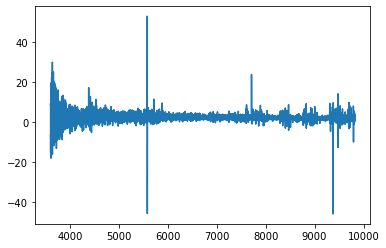

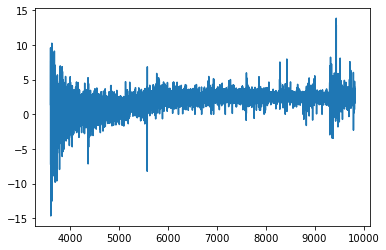

In [5]:

nw=7781
spectra=np.zeros([n,nw])
redshifted_waves=np.zeros([n,nw])
tic=time.time()
for j in range(n):
    coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[j])
    a=listdir(coadd_path)[0]
    coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[j])+"/"+a
    coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[j])+"/"+a\
                +"/coadd-"+str(petal_locs[j])+"-"+str(tile_ids[j])+"-thru"+str(a)+".fits"


    test=fits.open(coadd_path)
    wave_b=test["B_WAVELENGTH"].data
    flux_b=test["B_FLUX"].data[fiber_ids[j]%500,:]
    inv_var_b=test["B_IVAR"].data[fiber_ids[j]%500,:]
    wave_r=test["R_WAVELENGTH"].data
    flux_r=test["R_FLUX"].data[fiber_ids[j]%500,:]
    inv_var_r=test["R_IVAR"].data[fiber_ids[j]%500,:]
    wave_z=test["Z_WAVELENGTH"].data
    flux_z=test["Z_FLUX"].data[fiber_ids[j]%500,:]
    inv_var_z=test["Z_IVAR"].data[fiber_ids[j]%500,:]

    first=np.where(abs(wave_b-wave_r[0])<10**-4)[0][0]
    second=np.where(abs(wave_r-wave_z[0])<10**-4)[0][0]

    nw=first+second+len(wave_z)

    spectrum=np.zeros(nw)

    i2=np.arange(nw)-first
    i3=np.arange(nw)-(second+first)

    wavelength=np.zeros(nw)
    
    wavelength[:first]=wave_b[:first]
    wavelength[first:len(wave_b)]=(wave_b[first:len(wave_b)]+wave_r[i2[first:len(wave_b)]])/2
    wavelength[len(wave_b):second+first]=wave_r[i2[len(wave_b):second+first]]
    wavelength[second+first:first+len(wave_r)]=(wave_r[i2[second+first:first+len(wave_r)]]+wave_z[i3[second+first:first+len(wave_r)]])/2
    wavelength[first+len(wave_r):]=wave_z[i3[first+len(wave_r):]]
        
    spectrum[:first]=flux_b[:first]  
    spectrum[first:len(wave_b)]=(flux_b[first:len(wave_b)]*inv_var_b[first:len(wave_b)]+flux_r[i2[first:len(wave_b)]]*inv_var_r[i2[first:len(wave_b)]])\
                                /(inv_var_b[first:len(wave_b)]+inv_var_r[i2[first:len(wave_b)]])
    spectrum[len(wave_b):second+first]=flux_r[i2[len(wave_b):second+first]]
    spectrum[second+first:first+len(wave_r)]=(flux_r[i2[second+first:first+len(wave_r)]]*inv_var_r[i2[second+first:first+len(wave_r)]]+flux_z[i3[second+first:first+len(wave_r)]]*inv_var_z[i3[second+first:first+len(wave_r)]])\
                    /(inv_var_r[i2[second+first:first+len(wave_r)]]+inv_var_z[i3[second+first:first+len(wave_r)]])
    spectrum[first+len(wave_r):]=flux_z[i3[first+len(wave_r):]]

#     for i in range(nw):
#         if i<first:
#             wavelength[i]=wave_b[i]
#             spectrum[i]=flux_b[i]

#         if i>=first and i<len(wave_b):
#             wavelength[i]=(wave_b[i]+wave_r[i-first])/2
#             spectrum[i]=(flux_b[i]*inv_var_b[i]+flux_r[i-first]*inv_var_r[i-first])/(inv_var_b[i]+inv_var_r[i-first])

#         if i>=len(wave_b) and i<second+first:
#             wavelength[i]=wave_r[i-first]
#             spectrum[i]=flux_r[i-first]

#         if i>=second+first and i<first+len(wave_r):
#             wavelength[i]=(wave_r[i-first]+wave_z[i-(second+first)])/2
#             spectrum[i]=(flux_r[i-first]*inv_var_r[i-first]+flux_z[i-(second+first)]*inv_var_z[i-(second+first)])/(inv_var_r[i-first]+inv_var_z[i-(second+first)])

#         if i>=first+len(wave_r):
#             wavelength[i]=wave_z[i-(first+second)]
#             spectrum[i]=flux_z[i-(first+second)]
    
    spectra[j,:]=spectrum[:]
    redshifted_waves[j,:]=wavelength[:]/(1+zs[j])
print(time.time()-tic)

plt.figure(1)
plt.plot(wavelength,spectra[0,:])
plt.figure(2)
plt.plot(wavelength,spectra[-1,:])

(array([1.1000e+01, 1.6000e+01, 5.0000e+00, 3.5000e+01, 7.0800e+02,
        5.7830e+03, 1.3968e+04, 1.5710e+04, 1.0044e+04, 3.7200e+03]),
 array([3642.4450491 , 4260.5869493 , 4878.72884951, 5496.87074971,
        6115.01264991, 6733.15455011, 7351.29645032, 7969.43835052,
        8587.58025072, 9205.72215093, 9823.86405113]),
 <BarContainer object of 10 artists>)

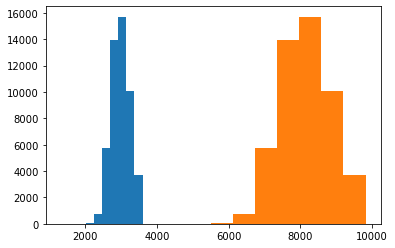

In [6]:
z_min=np.zeros(n)
z_max=np.zeros(n)

for i in range(n):
    z_min[i]=min(redshifted_waves[i,:])
    z_max[i]=max(redshifted_waves[i,:])
    
plt.figure(1)
plt.hist(z_min)
plt.hist(z_max)

In [7]:
# with open("/global/homes/a/ashodkh/results/spectra.txt",'w') as f:    
#     for i in range(n):
#         for j in range(nw-1):
#             f.write(str(np.round(spectra[i,j],decimals=4))+",")
#         f.write(str(np.round(spectra[i,-1],decimals=4))+"\n")
        
# with open("/global/homes/a/ashodkh/results/redshifted_waves.txt",'w') as f:    
#     for i in range(n):
#         for j in range(nw-1):
#             f.write(str(np.round(redshifted_waves[i,j],decimals=4))+",")
#         f.write(str(np.round(redshifted_waves[i,-1],decimals=4))+"\n")   
np.savez_compressed("/global/homes/a/ashodkh/results/spectra.txt",spectra)
np.savez_compressed("/global/homes/a/ashodkh/results/redshifted_waves.txt",redshifted_waves)